# readme:

This Jupyter Notebook can be used to search the Scielo Brazil network for desired keywords or phrases pertaining to research topics. For example, you can search for 'niobium', 'aerospace', or 'soybean biodiesel'. 

Note that if you search for a phrase with multiple words only clusters which contain all of that phrase's constituent words will show up in the results. Please do not include any punctuation in the search term. 

You can change the following parameters:
- the search term
- the search breadth, ie threshold for the minimum number of times a keyword must appear in a cluster to include it in search results
- the ID of the specific cluster you'd like to read through for detailed bibliographic information. Look at this after going through the first few steps - it's at the bottom of the page.

Don't change any of the other code or it won't work!

Follow the steps below to run a search. The parameters for a search is already entered that you can modify as you like. 

## Step 1: enter search term below in quotation marks

In [13]:
query = 'biofuel'

## Step 2: set search breadth from 1 to 5. 1 is broadest, 5 is narrowest

In [14]:
breadth = 2

## Step 3: at the top menu, go to Cell > Run All. Wait for code to run and scroll to output below. 

In [15]:
#don't change anything here
import copy
from collections import Counter
import pandas as pd
import numpy as np
import networkx as nx
import nltk
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from adjustText import adjust_text
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

nltk.download('punkt')

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

ps = PorterStemmer()
G1 = nx.read_gpickle('network_part1.pkl')
G2 = nx.read_gpickle('network_part2.pkl')
G3 = nx.read_gpickle('network_part3.pkl')
G4 = nx.read_gpickle('network_part4.pkl')
G = nx.compose(G1, G2)
G = nx.compose(G, G3)
G = nx.compose(G, G4)

groups = {}
grouplist = []
IDlist = []
x = []
y = []

for node in G.nodes():
    if type(node) == int:
        groups.setdefault(G.node[node]['group'],[]).extend(list(set(G.node[node]['TA_words'])))
        grouplist.append(G.node[node]['group'])
        IDlist.append(G.node[node]['index'])
        x.append(G.node[node]['viz']['position']['x'])
        y.append(G.node[node]['viz']['position']['y'])
        
nodeframe = pd.DataFrame({'ID': IDlist, 'Group': grouplist, 'x': x, 'y': y})

query = [ps.stem(item) for item in nltk.word_tokenize(query.lower())]
mycount = breadth
cluster_dict = {}
cluster_list = []
count_list = []
for i in groups:
    allthere = 1
    count = 9999
    for j in query:
        temp = groups[i].count(j)
        allthere = allthere * temp
        if temp < count:
            count = copy.deepcopy(temp)
    
    if count >= mycount and allthere > 0:
        cluster_dict[i] = {}
        cluster_dict[i]['nodes'] = []
        cluster_dict[i]['count'] = count
        count_list.append(cluster_dict[i]['count'])
        cluster_list.append(i)
        
for node in G.nodes():
    if G.node[node]['group'] in cluster_list:
        temp = copy.deepcopy(G.node[node])
        temp.pop('TA', None)
        temp.pop('TA_words', None)
        temp.pop('viz', None)
        cluster_dict[G.node[node]['group']]['nodes'].append(temp)
        
cluster_results = pd.DataFrame({'ID': cluster_list, 'hits': count_list})
cluster_results = cluster_results.set_index('ID')
cluster_results['# papers'] = 0
cluster_results['keywords'] = ''

for i in range(1,max(groups)+1):
    if i in cluster_results.index.values:
        cluster_results.loc[i, '# papers'] = len(cluster_dict[i]['nodes'])
        cluster_results.loc[i, 'keywords'] = ' '.join(t[0] for t in Counter(groups[i]).most_common(10))

nodehits = copy.deepcopy(nodeframe)
nodehits['bool'] = nodehits['Group'].isin(list(cluster_results.index))
nodehits = nodehits[nodehits['bool'] == True]
nodehits['group_color'] = pd.factorize(nodehits['Group'])[0]
cluster_results['x'] = nodehits.groupby('Group')['x'].mean()
cluster_results['y'] = nodehits.groupby('Group')['y'].mean()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Eric\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Step 4: view output below

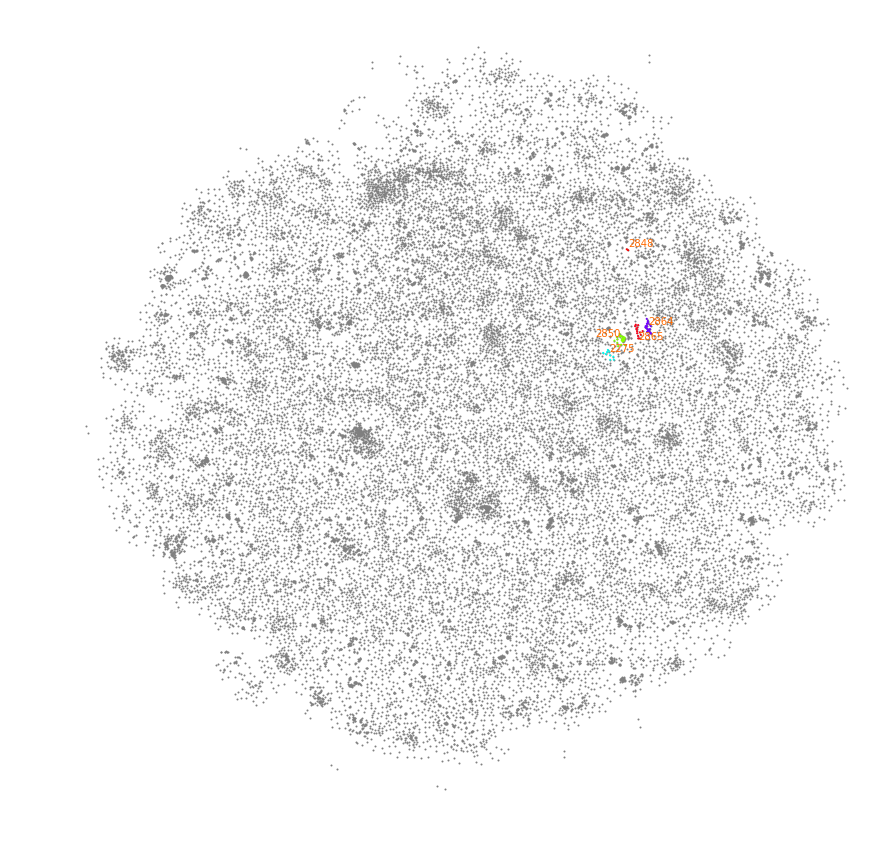

,hits,# papers,keywords
ID,,,
2275,2,2,isol step biofuel fungi ferment hydrolysi biomass xylanas enzym residu
2848,3,31,biodiesel oil fuel reaction ethanol liquid diesel acid non contain
2850,3,9,diesel fuel engin cycl blend combust emiss hydrocarbon ethanol biodiesel
2864,3,24,yeast ferment cell cerevisia saccharomyc strain acid industri reduct highest
2865,2,14,chemic acid cultiv composit third yeast ferment compound ratio batch


In [16]:
fig, ax = plt.subplots(figsize=(15,15))
ax.axis("off")
ax.scatter(np.array(nodeframe[['x' ,'y']])[:,0], np.array(nodeframe[['x' ,'y']])[:,1], c="gray", s=1)
ax.scatter(np.array(nodehits[['x', 'y']])[:,0], np.array(nodehits[['x', 'y']])[:,1], c=list(nodehits['group_color']), cmap = plt.get_cmap("hsv"), s=1)
texts = [plt.text(list(cluster_results['x'])[i], list(cluster_results['y'])[i], list(set(list(nodehits['Group'])))[i], color='#ff6a00') for i in range(len(list(cluster_results['x'])))]
adjust_text(texts)
    
cluster_results = cluster_results.drop(['x', 'y'], axis=1)

plt.show()  
cluster_results

## Step 5: enter the cluster ID you want to examine (from the output immediately above), then Run All again (or run just the cells below if you know how)

In [17]:
ID = 2275

## Step 6: view details for papers in selected cluster

In [18]:
cluster_dict[ID]['nodes']

[{'abstract': 'Producing biofuels such as ethanol from non-food plant material has the potential to meet transportation fuel requirements in many African countries without impacting directly on food security. The current shortcomings in biomass processing are inefficient fermentation of plant sugars, such as xylose, especially at high temperatures, lack of fermenting microbes that are able to resist inhibitors associated with pre-treated plant material and lack of effective lignocellulolytic enzymes for complete hydrolysis of plant polysaccharides. Due to the presence of residual partially degraded lignocellulose in the gut, the dung of herbivores can be considered as a natural source of pre-treated lignocellulose. A total of 101 fungi were isolated (36 yeast and 65 mould isolates). Six yeast isolates produced ethanol during growth on xylose while three were able to grow at 42 degC. This is a desirable growth temperature as it is closer to that which is used during the cellulose hydrol